### Setup GPU and Importing Libraries

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import random

In [54]:
if torch.backends.mps.is_available():
    device_gpu = torch.device("mps")
else:
    device_gpu = torch.device("cpu")

In [55]:
device_gpu

device(type='mps')

### Alphabet Setup

In [56]:
eng_alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
pad_char = "-PAD-"
eng_alpha2index = {pad_char:0}
for index,alpha in enumerate(eng_alphabet):
    eng_alpha2index[alpha]=index+1
print(eng_alpha2index)

{'-PAD-': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


In [57]:
hindi_alphabets = [chr(alpha) for alpha in range(2304,2432)]
hindi_alphabet_size = len(hindi_alphabets)
hindi_alpha2index = {pad_char:0}
for index,alpha in enumerate(hindi_alphabets):
    hindi_alpha2index[alpha]=index+1
print(hindi_alpha2index)

{'-PAD-': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '॑': 82, '॒': 83, '॓': 84, '॔': 85, 'ॕ': 86, 'ॖ': 87, 'ॗ': 88, 'क़': 89, 'ख़': 90, 'ग़': 91, 'ज़': 92, 'ड़': 93, 'ढ़': 94, 'फ़': 95, 'य़': 96, 'ॠ': 97, 'ॡ': 98, 'ॢ': 99, 'ॣ': 100, '।': 101, '॥': 102, '०': 103, '१': 104, '२': 105, '३': 106, '४': 107, '५': 108, '६': 109, '७': 

### Helper function for data preprocessing

In [58]:
import re
non_eng_letters_regex = re.compile('[^a-zA-Z ]')

In [59]:
def cleanEnglishVocab(line):
    line = line.replace('-', ' ').replace(',', ' ').upper()
    line = non_eng_letters_regex.sub('', line)
    return line.split()

In [60]:
def cleanHindiVocab(line):
    line = line.replace('-', ' ').replace(',', ' ')
    cleaned_line = ''
    for char in line:
        if char in hindi_alpha2index or char == ' ':
            cleaned_line += char
    return cleaned_line.split()

### Data Ingestion

In [61]:
from torch.utils.data import Dataset
import xml.etree.ElementTree as ET

class TransliterationDataLoader(Dataset):
    def __init__(self, filename):
        self.eng_words, self.hindi_words = self.readXmlDataset(filename, cleanHindiVocab)
        self.shuffle_indices = list(range(len(self.eng_words)))
        random.shuffle(self.shuffle_indices)
        self.shuffle_start_index = 0
        
    def __len__(self):
        return len(self.eng_words)
    
    def __getitem__(self, idx):
        return self.eng_words[idx], self.hindi_words[idx]
    
    def readXmlDataset(self, filename, lang_vocab_cleaner):
        transliterationCorpus = ET.parse(filename).getroot()
        lang1_words = []
        lang2_words = []

        for line in transliterationCorpus:
            wordlist1 = cleanEnglishVocab(line[0].text)
            wordlist2 = lang_vocab_cleaner(line[1].text)

            # Skip noisy data
            if len(wordlist1) != len(wordlist2):
                print('Skipping: ', line[0].text, ' - ', line[1].text)
                continue

            for word in wordlist1:
                lang1_words.append(word)
            for word in wordlist2:
                lang2_words.append(word)

        return lang1_words, lang2_words
    
    def get_random_sample(self):
        return self.__getitem__(np.random.randint(len(self.eng_words)))
    
    def get_batch_from_array(self, batch_size, array):
        end = self.shuffle_start_index + batch_size
        batch = []
        if end >= len(self.eng_words):
            batch = [array[i] for i in self.shuffle_indices[0:end%len(self.eng_words)]]
            end = len(self.eng_words)
        return batch + [array[i] for i in self.shuffle_indices[self.shuffle_start_index : end]]
    
    def get_batch(self, batch_size, postprocess = True):
        eng_batch = self.get_batch_from_array(batch_size, self.eng_words)
        hindi_batch = self.get_batch_from_array(batch_size, self.hindi_words)
        self.shuffle_start_index += batch_size + 1
        
        # Reshuffle if 1 epoch is complete
        if self.shuffle_start_index >= len(self.eng_words):
            random.shuffle(self.shuffle_indices)
            self.shuffle_start_index = 0
            
        return eng_batch, hindi_batch

In [62]:
train_data = TransliterationDataLoader('NEWS2012TrainingEnHi13937.xml')
test_data = TransliterationDataLoader('NEWS2012RefEnHi1000.xml')

Skipping:  BARHARWA JUNCTION  -  बरहरवा
Skipping:  STATE BNK TR  -  स्टेट बैंक ऑफ त्रावणकोर
Skipping:  SOUTH ARLINGTON CHURCH OF CHRIST  -  साउथ अर्लिंग्टन
Skipping:  KING EDWARD VII  -  किंग एडवर्ड
Skipping:  DIBANG VALLEY  -  दिबंगवैली
Skipping:  ORDER OF VASA  -  ऑडर ऑफ़ द वासा
Skipping:  AZAMNAGAR ROAD  -  आज़मनगर
Skipping:  CAPE TOWN  -  केपटाउन
Skipping:  NEW ZEALAND  -  न्यूज़ीलैंड
Skipping:  SEA OF THE HEBRIDES  -  सी ऑफ हरब्रिड्‍स
Skipping:  RAMCOIND  -  राम्को इंड
Skipping:  KELVINGROVE ART GALLERY AND MUSEUM  -  केल्व‍िनग्रोव आर्ट एण्ड म्युज़ियम
Skipping:  AUSTRALIAN NATIONAL UNIVERSITY  -  ऑस्ट्रेलियननेशनल यूनिवर्सिटी
Skipping:  JAHAN AARA  -  जहाँआरा
Skipping:  NAVABHARAT FERRO ALLOYS  -  नव भारत फ़ैरो अलॉय
Skipping:  RAMA LINGESHWARA  -  रामालिंगेश्वर
Skipping:  FAKHRUN NISA  -  फखरुन्निसा
Skipping:  REDIFF.COM INDIA LIMITED  -  रेडिफ़ डॉट कॉम इंडिया लिमिटेड
Skipping:  OMKARNATH THAKUR  -  ओंकार नाथ ठाकुर
Skipping:  OPENTV  -  ओपन टीवी
Skipping:  ENVOY COMMUNICATIONS GROUP  

### Visualizing data

In [63]:
print("Train Set Size:\t", len(train_data))
print("Test Set Size:\t", len(test_data))

print('\nSample data from train-set:')
for i in range(10):
    eng, hindi = train_data.get_random_sample()
    print(eng + ' - ' + hindi)

Train Set Size:	 20543
Test Set Size:	 1000

Sample data from train-set:
MAHON - महोन
FAWZI - फावज़ी
INDIA - इंडिया
KALAMATA - कलमाटा
KEEMAT - कीमत
PYAASA - प्यासा
FORT - फोर्ट
AMRITASH - अमृताश
BOXER - बॉक्सर
ETHAN - एथन


### Encoding Words

In [64]:
##encoding the english input
def word_rep(word,letter2index,device="cpu"):
    rep = torch.zeros(len(word)+1,1,len(letter2index)).to(device)
    for letter_index,letter in enumerate(word):
        pos = letter2index[letter]
        rep[letter_index][0][pos]=1
    pad_pos=letter2index[pad_char]
    rep[letter_index+1][0][pad_pos]=1
    return rep

In [65]:
##encoding the hindi output
def gt_rep(word,letter2index,device="cpu"):
    gt_rep = torch.zeros([len(word)+1,1],dtype=torch.long).to(device)
    for letter_index,letter in enumerate(word):
        pos = letter2index[letter]
        gt_rep[letter_index][0]=pos
    gt_rep[letter_index+1][0] = letter2index[pad_char]
    return gt_rep

In [66]:
eng, hindi = train_data.get_random_sample()
eng_rep = word_rep(eng, eng_alpha2index)
print(eng, eng_rep)

SHERE tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])


In [67]:
hindi_gt = gt_rep(hindi, hindi_alpha2index)
print(hindi, hindi_gt)

शेर tensor([[55],
        [72],
        [49],
        [ 0]])


### Encoder Decoder Network Architecture(GRU)

In [68]:
MAX_OUTPUT_CHAR = 30
class Transliteration_EncoderDecoder(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, verbose=False):
        super(Transliteration_EncoderDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.encoder_rnn_cell = nn.GRU(input_size,hidden_size)
        self.decoder_rnn_cell = nn.GRU(output_size,hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
        self.verbose = verbose

    def forward(self,input,max_output_chars = MAX_OUTPUT_CHAR,device='cpu',ground_truth = None):
        #encoder
        out,hidden = self.encoder_rnn_cell(input)
        if self.verbose:
            print('Encoder input', input.shape)
            print('Encoder output', out.shape)
            print('Encoder hidden', hidden.shape)
        #decoder
        decoder_state = hidden
        decoder_input = torch.zeros(1,1,self.output_size).to(device)
        outputs = []
        if self.verbose:
            print('Decoder state',decoder_state.shape)
            print('Decoder input', decoder_input.shape)
        for i in range(max_output_chars):
            out, decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state)
            if self.verbose:
                print('Decoder intermediate output', out.shape)
            out = self.h2o(decoder_state)
            out = self.softmax(out)
            outputs.append(out.view(1,-1))
            if self.verbose:
                print('Decoder output', out.shape)
                self.verbose = False
            max_idx = torch.argmax(out, 2, keepdim=True)
            if not ground_truth is None:
                max_idx = ground_truth[i].reshape(1, 1, 1)
            one_hot = torch.FloatTensor(out.shape).to(device)
            one_hot.zero_()
            one_hot.scatter_(2, max_idx, 1)
            
            decoder_input = one_hot.detach()
            
        return outputs

In [69]:
net = Transliteration_EncoderDecoder(len(eng_alpha2index), 256, len(hindi_alpha2index), verbose=True)

### Encoder Decoder with Attention

In [71]:
class Transliteration_EncoderDecoder_Attention(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, verbose=False):
        super(Transliteration_EncoderDecoder_Attention, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.encoder_rnn_cell = nn.GRU(input_size, hidden_size)
        self.decoder_rnn_cell = nn.GRU(hidden_size*2, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
        self.U = nn.Linear(self.hidden_size, self.hidden_size)
        self.W = nn.Linear(self.hidden_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size, 1)
        self.out2hidden = nn.Linear(self.output_size, self.hidden_size)   
        self.verbose = verbose
        
    def forward(self, input, max_output_chars = MAX_OUTPUT_CHAR, device = 'cpu', ground_truth = None):
        # encoder
        encoder_outputs, hidden = self.encoder_rnn_cell(input)
        encoder_outputs = encoder_outputs.view(-1, self.hidden_size)
        if self.verbose:
            print('Encoder output', encoder_outputs.shape)
        # decoder
        decoder_state = hidden
        decoder_input = torch.zeros(1, 1, self.output_size).to(device)       
        outputs = []
        U = self.U(encoder_outputs)   
        if self.verbose:
            print('Decoder state', decoder_state.shape)
            print('Decoder intermediate input', decoder_input.shape)
            print('U * Encoder output', U.shape)
        for i in range(max_output_chars):   
            W = self.W(decoder_state.view(1, -1).repeat(encoder_outputs.shape[0], 1))
            V = self.attn(torch.tanh(U + W))
            attn_weights = F.softmax(V.view(1, -1), dim = 1) 
            if self.verbose:
                print('W * Decoder state', W.shape)
                print('V', V.shape)
                print('Attn', attn_weights.shape)
            attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
            embedding = self.out2hidden(decoder_input)
            decoder_input = torch.cat((embedding[0], attn_applied[0]), 1).unsqueeze(0)
            if self.verbose:
                print('Attn LC', attn_applied.shape)
                print('Decoder input', decoder_input.shape)   
            out, decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state)
            if self.verbose:
                print('Decoder intermediate output', out.shape)   
            out = self.h2o(decoder_state)
            out = self.softmax(out)
            outputs.append(out.view(1, -1))
            if self.verbose:
                print('Decoder output', out.shape)
                self.verbose = False   
            max_idx = torch.argmax(out, 2, keepdim=True)
            if not ground_truth is None:
                max_idx = ground_truth[i].reshape(1, 1, 1)
            one_hot = torch.zeros(out.shape, device=device)
            one_hot.scatter_(2, max_idx, 1) 
            decoder_input = one_hot.detach()   
        return outputs

In [72]:
net_attn = Transliteration_EncoderDecoder_Attention(len(eng_alpha2index), 256, len(hindi_alpha2index), verbose=True)

### Training

In [74]:
def train_batch(net, opt, criterion, batch_size, device = 'cpu', teacher_force = False):
    
    net.train().to(device)
    opt.zero_grad()
    eng_batch, hindi_batch = train_data.get_batch(batch_size)
    
    total_loss = 0
    for i in range(batch_size):
        
        input = word_rep(eng_batch[i], eng_alpha2index, device)
        gt = gt_rep(hindi_batch[i], hindi_alpha2index, device)
        outputs = net(input, gt.shape[0], device, ground_truth = gt if teacher_force else None)
        
        for index, output in enumerate(outputs):
            loss = criterion(output, gt[index]) / batch_size
            loss.backward(retain_graph = True)
            total_loss += loss
        
    opt.step()
    return total_loss/batch_size

In [75]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu'):
    
    net = net.to(device)
    criterion = nn.NLLLoss(ignore_index = -1)
    opt = optim.Adam(net.parameters(), lr=lr)
    teacher_force_upto = n_batches//3
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device = device, teacher_force = i<teacher_force_upto ))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
            
    torch.save(net, 'model.pt')
    return loss_arr

In [76]:
net = Transliteration_EncoderDecoder(len(eng_alpha2index), 256, len(hindi_alpha2index))

Iteration 1999 Loss 0.17492173612117767


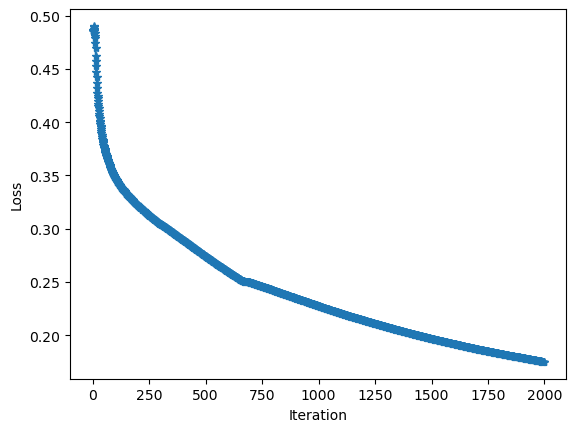

array([0.        , 0.48523381, 0.48645389, ..., 0.17495912, 0.17492174,
       0.17487863])

In [77]:
train_setup(net, lr=0.001, n_batches=2000, batch_size = 64, display_freq=10, device = device_gpu)

In [78]:
net_att = Transliteration_EncoderDecoder_Attention(len(eng_alpha2index), 256, len(hindi_alpha2index))

Iteration 1999 Loss 0.1370716243982315


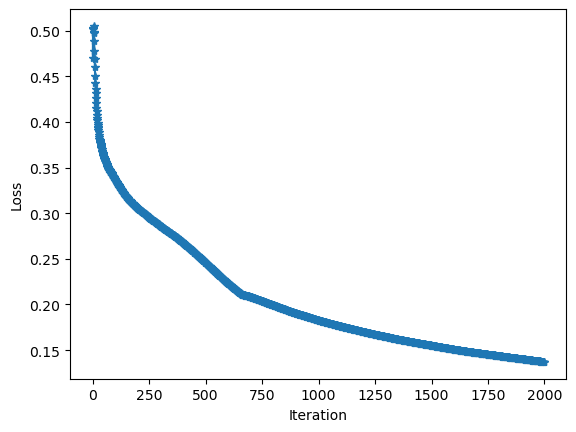

In [79]:
loss_history = train_setup(net_att, lr=0.001, n_batches=2000, batch_size = 64, display_freq=10, device = device_gpu)

In [152]:
loss_history

array([0.        , 0.46942469, 0.50268662, ..., 0.13710243, 0.13707162,
       0.13703471])

In [157]:
eng_alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
pad_char = "-PAD-"
eng_alpha2index = {pad_char: 0}
for index, alpha in enumerate(eng_alphabet):
    eng_alpha2index[alpha] = index + 1

print("English alpha2index:", eng_alpha2index)

English alpha2index: {'-PAD-': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


In [158]:
hindi_alphabets = [chr(alpha) for alpha in range(2304, 2432)]
hindi_alphabet_size = len(hindi_alphabets)
hindi_alpha2index = {pad_char: 0}
for index, alpha in enumerate(hindi_alphabets):
    hindi_alpha2index[alpha] = index + 1

print("Hindi alpha2index:", hindi_alpha2index)

Hindi alpha2index: {'-PAD-': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '॑': 82, '॒': 83, '॓': 84, '॔': 85, 'ॕ': 86, 'ॖ': 87, 'ॗ': 88, 'क़': 89, 'ख़': 90, 'ग़': 91, 'ज़': 92, 'ड़': 93, 'ढ़': 94, 'फ़': 95, 'य़': 96, 'ॠ': 97, 'ॡ': 98, 'ॢ': 99, 'ॣ': 100, '।': 101, '॥': 102, '०': 103, '१': 104, '२': 105, '३': 106, '४': 107, '५': 1

In [159]:
hindi_index2alpha = {index: alpha for alpha, index in hindi_alpha2index.items()}
print("Hindi index2alpha:", hindi_index2alpha)

Hindi index2alpha: {0: '-PAD-', 1: 'ऀ', 2: 'ँ', 3: 'ं', 4: 'ः', 5: 'ऄ', 6: 'अ', 7: 'आ', 8: 'इ', 9: 'ई', 10: 'उ', 11: 'ऊ', 12: 'ऋ', 13: 'ऌ', 14: 'ऍ', 15: 'ऎ', 16: 'ए', 17: 'ऐ', 18: 'ऑ', 19: 'ऒ', 20: 'ओ', 21: 'औ', 22: 'क', 23: 'ख', 24: 'ग', 25: 'घ', 26: 'ङ', 27: 'च', 28: 'छ', 29: 'ज', 30: 'झ', 31: 'ञ', 32: 'ट', 33: 'ठ', 34: 'ड', 35: 'ढ', 36: 'ण', 37: 'त', 38: 'थ', 39: 'द', 40: 'ध', 41: 'न', 42: 'ऩ', 43: 'प', 44: 'फ', 45: 'ब', 46: 'भ', 47: 'म', 48: 'य', 49: 'र', 50: 'ऱ', 51: 'ल', 52: 'ळ', 53: 'ऴ', 54: 'व', 55: 'श', 56: 'ष', 57: 'स', 58: 'ह', 59: 'ऺ', 60: 'ऻ', 61: '़', 62: 'ऽ', 63: 'ा', 64: 'ि', 65: 'ी', 66: 'ु', 67: 'ू', 68: 'ृ', 69: 'ॄ', 70: 'ॅ', 71: 'ॆ', 72: 'े', 73: 'ै', 74: 'ॉ', 75: 'ॊ', 76: 'ो', 77: 'ौ', 78: '्', 79: 'ॎ', 80: 'ॏ', 81: 'ॐ', 82: '॑', 83: '॒', 84: '॓', 85: '॔', 86: 'ॕ', 87: 'ॖ', 88: 'ॗ', 89: 'क़', 90: 'ख़', 91: 'ग़', 92: 'ज़', 93: 'ड़', 94: 'ढ़', 95: 'फ़', 96: 'य़', 97: 'ॠ', 98: 'ॡ', 99: 'ॢ', 100: 'ॣ', 101: '।', 102: '॥', 103: '०', 104: '१', 105: '२', 106: '३', 107: '४', 108: '